# Turbulent Channel (Reynolds 180)

The simulation of a periodic turbulent channel is also used for validation of a multilevel domain. A friction Reynolds number of 180 is fixed for both cases. The pressure gradient is estabilished through a constant body force.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/04_turbulent_channel_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

The multilevel setup tries to reproduce a DNS using a optimized amount of grid nodes.

In [2]:
sim_cfg_mb = next(
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if sim_cfg.name == "periodicTurbulentChannelMultilevel"
)
sim_cfgs_use = {"mb": sim_cfg_mb}

Functions to use for turbulence channel processing

In [3]:
import pandas as pd
import numpy as np
import pathlib
from nassu.cfg.schemes.simul import SimulationConfigs
from vtk.util.numpy_support import vtk_to_numpy
from tests.validation.notebooks import common


def get_experimental_profiles(reynolds_tau: float) -> dict[str, pd.DataFrame]:
    files_tau: dict[float, dict[str, str]] = {
        142: {
            "ux": "Turbulent_channel/Re_tau_142/u_avg.csv",
            "ux_rms": "Turbulent_channel/Re_tau_142/u_rms.csv",
            "uy_rms": "Turbulent_channel/Re_tau_142/v_rms.csv",
            "uz_rms": "Turbulent_channel/Re_tau_142/w_rms.csv",
        },
        520: {
            "ux": "Turbulent_channel/Re_tau_520/u_avg.csv",
            "ux_rms": "Turbulent_channel/Re_tau_142/u_rms.csv",
        },
    }

    files_get = files_tau[reynolds_tau]
    vals_exp: dict[str, pd.DataFrame] = {}
    for name, comp_file in files_get.items():
        filename = pathlib.Path("tests/validation/comparison") / comp_file
        df = pd.read_csv(filename, delimiter=",")
        vals_exp[name] = df
    return vals_exp


def get_height_scale(sim_cfg: SimulationConfigs, reynolds_tau: float, u_ref: float) -> float:
    kin_visc = sim_cfg.models.LBM.kinematic_viscosity
    return u_ref / kin_visc


reader_output = {}
for name, sim_cfg in sim_cfgs_use.items():
    stats_export = sim_cfg.output.stats["default"]
    last_step = stats_export.interval.get_all_process_steps(sim_cfg.n_steps)[-1]
    reader = stats_export.read_vtm_export(last_step)
    reader_output[sim_cfg.name] = reader.GetOutput()


def get_macr_compressed(
    sim_cfg: SimulationConfigs, macr_name: str, is_2nd_order: bool
) -> np.ndarray:
    global reader, reader_output

    output_use = reader_output[sim_cfg.name]

    macr_name_read = macr_name if not is_2nd_order else f"{macr_name}_2nd"
    ds = sim_cfg.domain.domain_size

    p0 = np.array((ds.x // 2, 0, ds.z // 2))
    p1 = np.array((ds.x // 2, ds.y - 1, ds.z // 2))
    n_points = ds.y
    pos = np.linspace(p0, p1, num=n_points, endpoint=True)
    norm_pos = (pos[:, 1] + 0.5) / (len(pos) + 1)

    # Sum 0.5 because data is cell centered in vtm
    line = common.create_line(p0 + 0.5, p1 + 0.5, n_points - 1)

    probe_filter = common.probe_over_line(line, output_use)
    probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(macr_name_read))

    return np.array([norm_pos, probed_data])

## Results

The average velocity profile is shown for the case. It can be a good approximation from reference results for the multilevel case.

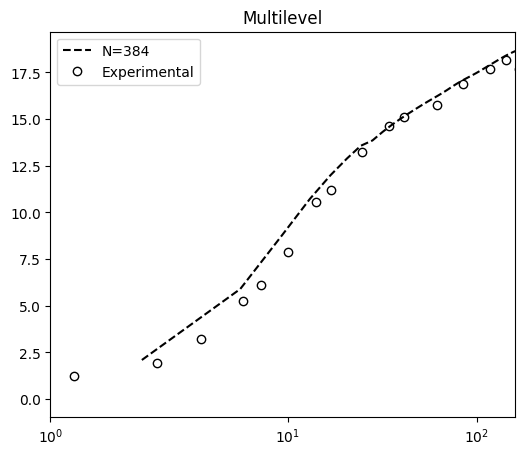

In [4]:
import matplotlib.pyplot as plt

# Despite the reynolds value being 180, the experimental data for 142 and 180 is pretty much the same
reynolds_tau = 142
u_ref = 0.00529

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 5)

for i, sim_cfg in enumerate(sim_cfgs_use.values()):
    height_scale = get_height_scale(sim_cfg, reynolds_tau, u_ref)

    analytical_values = get_experimental_profiles(reynolds_tau)

    macr_compr = get_macr_compressed(sim_cfg, "ux", is_2nd_order=False)
    y = macr_compr[0].copy()
    ux_avg = macr_compr[1].copy()

    ux_avg /= u_ref
    y *= height_scale * sim_cfg.domain.domain_size.y

    exp_y = analytical_values["ux"]["y+"]
    exp_ux_avg = analytical_values["ux"]["u/u*"]

    ax.plot(y, ux_avg, "--k", label=f"N={sim_cfg.domain.domain_size.x}")
    ax.plot(exp_y, exp_ux_avg, "ok", label="Experimental", fillstyle="none")

    ax.set_title("Multilevel")

    ax.legend()
    ax.set_xlim(1, 160)
    ax.set_xscale("symlog")

The results of the ${\mathrm{u_{rms}}}$ velocity profiles shown below also indicate a good representation with the multilevel approach.

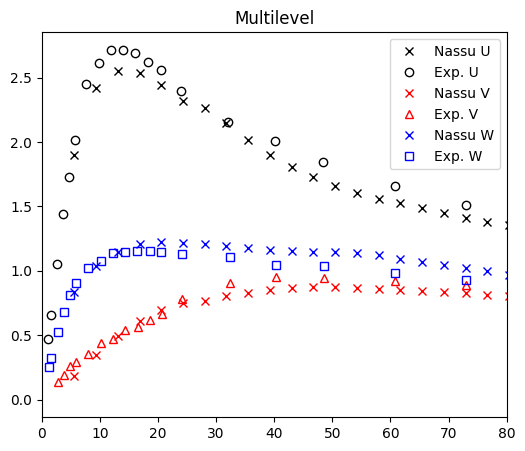

In [5]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 5)

vel_name_map = {"ux": "u", "uy": "v", "uz": "w"}

for i, sim_cfg in enumerate(sim_cfgs_use.values()):
    for macr_name, marker, color in [("ux", "o", "k"), ("uy", "^", "r"), ("uz", "s", "b")]:
        macr_compr_rms = get_macr_compressed(sim_cfg, macr_name, is_2nd_order=True)
        macr_compr_avg = get_macr_compressed(sim_cfg, macr_name, is_2nd_order=False)

        y = macr_compr_rms[0].copy()
        vel_2nd = macr_compr_rms[1].copy()
        vel_avg = macr_compr_avg[1].copy()
        vel_rms = (vel_2nd - vel_avg**2) ** 0.5

        vel_rms /= u_ref
        y *= height_scale * sim_cfg.domain.domain_size.y
        # Remove wall value
        vel_rms = vel_rms[1:]
        y = y[1:]

        name_vel = vel_name_map[macr_name]
        df = analytical_values[f"{macr_name}_rms"]
        exp_y = df["y+"]
        exp_rms = df[f"{name_vel}'/u*"]

        ax.plot(y, vel_rms, f"x{color}", label=f"Nassu {name_vel.upper()}")
        ax.plot(
            exp_y, exp_rms, f"{marker}{color}", label=f"Exp. {name_vel.upper()}", fillstyle="none"
        )

    ax.set_title("Multilevel")

    ax.legend()
    ax.set_xlim(0, 80)

## Version

In [6]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 09c9337ca174e12ce2cfa6eb39867054691a2742


## Configuration

In [7]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicTurbulentChannel
    save_path: ./tests/validation/results/04_turbulent_channel_flow/

    n_steps: 600000
    report:
      frequency: 1000

    domain:
      # u* = 0.00493 / l = 64 / ETT = l/u* = 12,984
      # Re_tau = 142
      # y+ = 2.0
      domain_size:
        x: 512
        y: 128
        z: 128
      block_size: 8

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 200000 }, macrs: [rho, u, S] }
      statistics:
        interval: { frequency: 100, start_step: 300000 }
        macrs_1st_order: [rho, u]
        macrs_2nd_order: [u]
        exports:
          default: { interval: { frequency: 50000 } }

    models:
      precision:
        default: single

      LBM:
        tau: 0.5074
        F:
          x: 4.72e-7
          y: 0
          z: 0
        vel_set: D3Q27
        coll_oper: RRBGK
      initialization:
        vtm_filename: "../nassuArtifacts/macrs/turbulent_channel.vtm"

      engine:
        name: CUDA

      BC:
        periodic_dims: [true, false, true]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 1

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 1

  - name: periodicTurbulentChannelMultilevel
    save_path: ./tests/validation/results/04_turbulent_channel_flow/

    n_steps: 200000
    # u* = 0.00525 / l = 48 / ETT = l/u* = 9,150
    # Re_tau = 180
    # y+ = 3.75 (lvl 0)

    report:
      frequency: 1000

    domain:
      domain_size:
        x: 384
        y: 96
        z: 96
      block_size: 8
      refinement:
        static:
          default:
            volumes_refine:
              - start: [0, 0, 0]
                end: [384, 8, 96]
                lvl: 1
                is_abs: true
              - start: [0, 88, 0]
                end: [384, 96, 96]
                lvl: 1
                is_abs: true

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 200000 }, macrs: [rho, u, S] }
        start_simul:
          { interval: { end_step: 2000, frequency: 500 }, macrs: [rho, u, S] }
      statistics:
        interval: { frequency: 50, start_step: 50000 }
        macrs_1st_order: [rho, u]
        macrs_2nd_order: [u]
        exports:
          default: { interval: { frequency: 50000 } }

    models:
      precision:
        default: single

      LBM:
        tau: 0.5042
        F:
          x: 5.75e-7
          y: 0
          z: 0
        vel_set: D3Q27
        coll_oper: RRBGK
      initialization:
        vtm_filename: "../nassuArtifacts/macrs/turbulent_channel.vtm"

      engine:
        name: CUDA

      BC:
        periodic_dims: [true, false, true]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 1

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 1